<a href="https://colab.research.google.com/github/ladofa/edu/blob/master/Example_kakao_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2


In [2]:
!git clone https://github.com/ladofa/edu

Cloning into 'edu'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 35 (delta 2), reused 33 (delta 2), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [3]:
root = 'edu/samples/kakao-color/'

#학습 데이터 준비

In [4]:
x_images = []
y_images = []

for i in range(10):
    x_filename = root+'colormap_%d.png' % i
    y_filename = root+'w%d.jpg' % i
    x_image = cv2.imread(x_filename).reshape(-1, 3)
    x_images.append(x_image)
    y_image = cv2.imread(y_filename).reshape(-1, 3)
    y_images.append(y_image)

In [5]:
x_pixels = np.concatenate(x_images, axis=0)
y_pixels = np.concatenate(y_images, axis=0)
rand_idx = np.random.permutation(x_pixels.shape[0])
x_pixels = x_pixels[rand_idx]
y_pixels = y_pixels[rand_idx]

In [6]:
x_images = np.array_split(x_pixels, 10 * 64 * 64) #64 * 8 = 512
y_images = np.array_split(y_pixels, 10 * 64 * 64) #64 * 8 = 512

In [7]:
x_train = np.array([image.reshape(8, 8, 3) for image in x_images])
y_train = np.array([image.reshape(8, 8, 3) for image in y_images])

In [8]:
x_valid = cv2.imread(root+'test.jpg')[None] 
y_valid = cv2.imread(root+'test_w.jpg')[None]

#일반적 딥러닝 모델

In [9]:
def htanh(x):
    return tf.nn.relu6(x * 3 + 3) / 3 - 1

[]

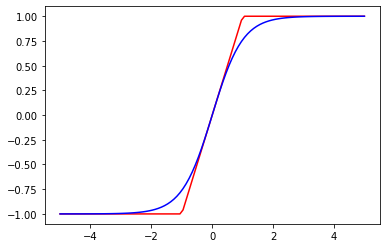

In [10]:
x = np.linspace(-5, 5, 100)
y1 = htanh(x).numpy()
y2 = np.tanh(x)
plt.plot(x, y1, 'r-')
plt.plot(x, y2, 'b-')
plt.plot()

In [11]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[None, None, 3]),
    keras.layers.Lambda(lambda x: x / 127.5 - 1),
    # keras.layers.BatchNormalization(),

    keras.layers.Dense(8, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('tanh'),
    # keras.layers.Lambda(htanh),

    keras.layers.Dense(8, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('tanh'),
    # keras.layers.Lambda(htanh),

    keras.layers.Dense(3),
    keras.layers.Lambda(lambda x: x  * 127.5 + 127.5),
    keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0, 255))
])

model.compile(loss='mse', optimizer='nadam')

In [12]:
model.fit(x_train, y_train, batch_size=512, epochs=200, validation_data=(x_valid, y_valid))

Epoch 1/200
80/80 [==============================] - 6s 7ms/step - loss: 5967.0474 - val_loss: 2064.6853
Epoch 2/200
80/80 [==============================] - 0s 4ms/step - loss: 813.2885 - val_loss: 1188.1165
Epoch 3/200
80/80 [==============================] - 0s 4ms/step - loss: 486.0284 - val_loss: 624.1108
Epoch 4/200
80/80 [==============================] - 0s 4ms/step - loss: 377.9523 - val_loss: 385.4697
Epoch 5/200
80/80 [==============================] - 0s 4ms/step - loss: 309.5219 - val_loss: 278.1845
Epoch 6/200
80/80 [==============================] - 0s 4ms/step - loss: 258.1049 - val_loss: 214.4621
Epoch 7/200
80/80 [==============================] - 0s 4ms/step - loss: 217.6183 - val_loss: 175.3360
Epoch 8/200
80/80 [==============================] - 0s 4ms/step - loss: 185.1446 - val_loss: 149.5132
Epoch 9/200
80/80 [==============================] - 0s 4ms/step - loss: 159.3691 - val_loss: 132.5319
Epoch 10/200
80/80 [==============================] - 0s 4ms/step - lo

In [13]:
model.evaluate(x_valid, y_valid)

1/1 [==============================] - 0s 41ms/step - loss: 39.4277


39.42769241333008

In [14]:
final_model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.cast(x, tf.float32)),
    model,
    keras.layers.Lambda(lambda x: tf.cast(x, tf.uint8)),
])

In [15]:
test_image = cv2.imread(root+'test.jpg')

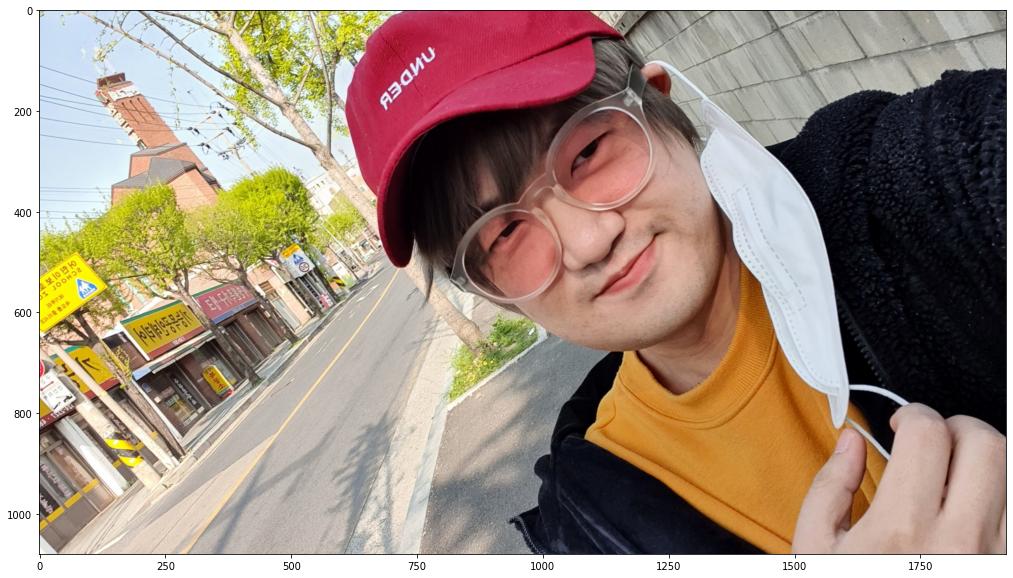

In [16]:
plt.figure(figsize=(20, 10))
plt.imshow(test_image[..., [2, 1, 0]])

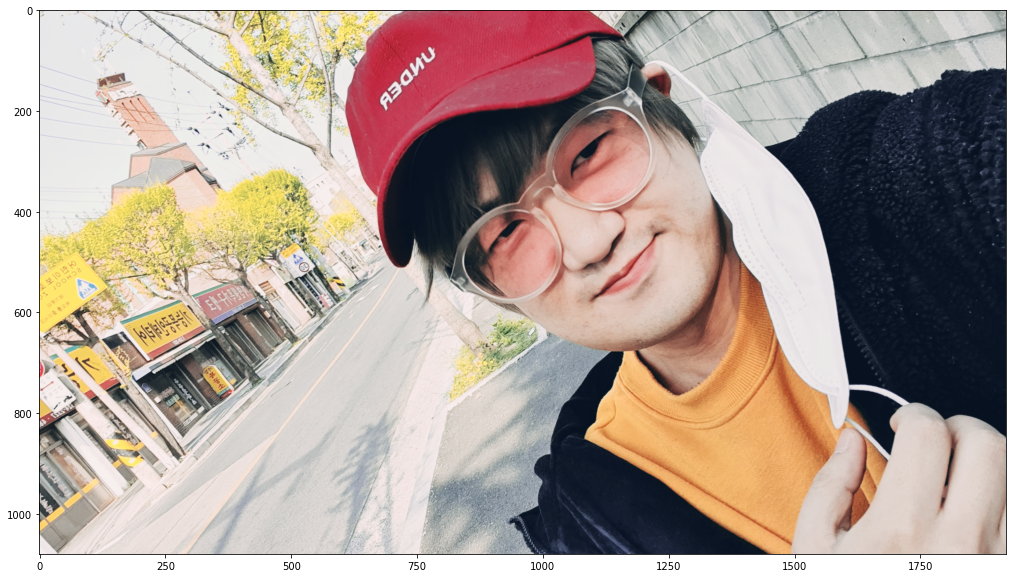

In [17]:
dst = final_model.predict(test_image[None])[0]
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

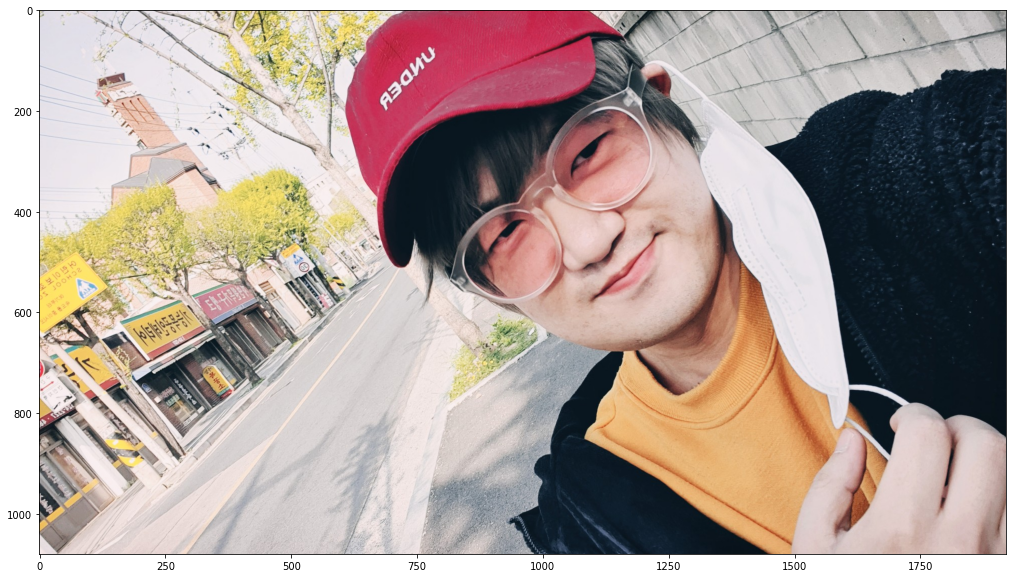

In [18]:
test_image_w = cv2.imread(root+'test_w.jpg')
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(test_image_w, cv2.COLOR_BGR2RGB))

#TensorFlow Lite

In [19]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(final_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppc65obo_/assets


In [20]:
lite_model = tf.lite.Interpreter('model.tflite')
input_detail = lite_model.get_input_details()
output_detail = lite_model.get_output_details()

In [21]:
output_detail

[{'dtype': numpy.uint8,
  'index': 61,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1, 1, 3], dtype=int32),
  'shape_signature': array([-1, -1, -1,  3], dtype=int32),
  'sparsity_parameters': {}}]

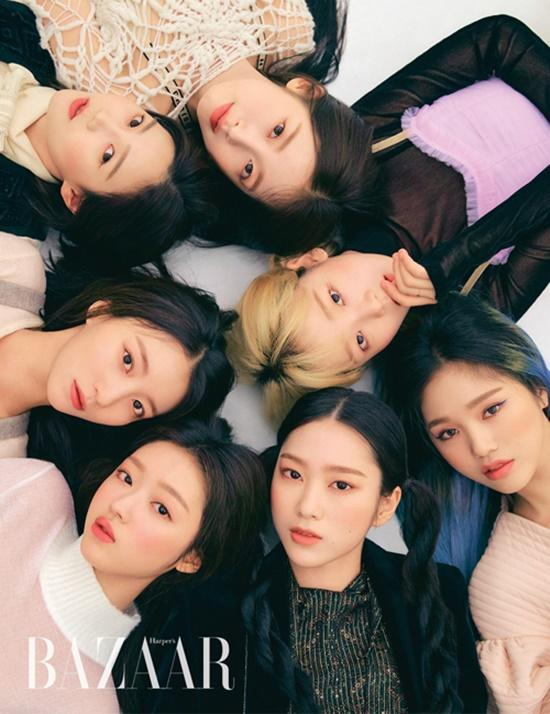

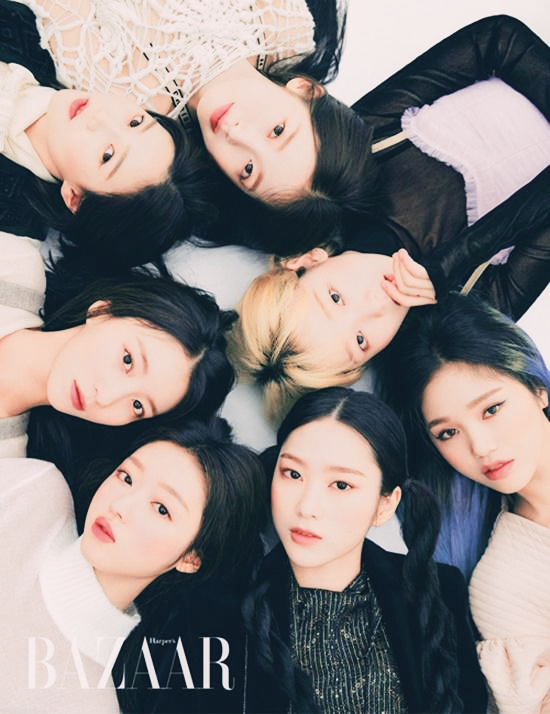

In [22]:
test_image = cv2.imread('test.jpg')
lite_model.resize_tensor_input(input_detail[0]['index'], (1,) + test_image.shape)
lite_model.allocate_tensors()
lite_model.set_tensor(input_detail[0]['index'], test_image[None])
lite_model.invoke()
output = lite_model.get_tensor(output_detail[0]['index'])[0]
cv2_imshow(test_image)
cv2_imshow(output)

프레임워크 독립적인 구현

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 dense (Dense)               (None, None, None, 8)     24        
                                                                 
 batch_normalization (BatchN  (None, None, None, 8)    32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, None, 8)     0         
                                                                 
 dense_1 (Dense)             (None, None, None, 8)     64        
                                                                 
 batch_normalization_1 (Batc  (None, None, None, 8)    32        
 hNormalization)                                        

In [24]:
model.layers[1].weights

[<tf.Variable 'dense/kernel:0' shape=(3, 8) dtype=float32, numpy=
 array([[-0.46623424,  0.5675884 , -0.07791485, -0.22292112, -0.4009416 ,
         -0.14655009,  0.80897397,  0.3044145 ],
        [-0.4472427 ,  0.5106075 , -1.1085693 , -0.06696223, -0.53725827,
          0.0770762 , -0.13291705,  0.32714462],
        [ 0.5235209 , -0.1302647 , -0.00399466,  0.9409961 ,  0.24397862,
         -0.4492344 , -0.02719541, -0.22438763]], dtype=float32)>]

In [25]:
model.layers[2].weights

[<tf.Variable 'batch_normalization/gamma:0' shape=(8,) dtype=float32, numpy=
 array([1.9582194 , 0.67627966, 0.8560475 , 1.6551877 , 0.96656555,
        0.9806653 , 1.6145898 , 1.5939877 ], dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(8,) dtype=float32, numpy=
 array([ 0.39530647,  0.56098986, -0.39994144,  0.11850148, -0.20999114,
        -0.30007422,  0.6117636 ,  0.2861201 ], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_mean:0' shape=(8,) dtype=float32, numpy=
 array([-0.03413035, -0.07536571,  0.16090131, -0.20404539,  0.0415594 ,
         0.10678586, -0.02575035, -0.01093315], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_variance:0' shape=(8,) dtype=float32, numpy=
 array([0.5224589 , 0.46670082, 0.59409225, 0.6213687 , 0.37778705,
        0.13822751, 0.37609637, 0.19113946], dtype=float32)>]

In [26]:
d = model.layers[1].weights[0]
gamma, beta, mean, variance = model.layers[2].weights
# (x @ d - mean) / sigma * gamma + beta = x @ (d * gamma / sigma) - (mean * gamma / sigma + beta) = x @ a + b
sigma = tf.sqrt(variance + 0.001)
a1 = d * gamma / sigma
b1 = - mean * gamma / sigma + beta

In [27]:
d = model.layers[4].weights[0]
gamma, beta, mean, variance = model.layers[5].weights
sigma = tf.sqrt(variance + 0.001)
# (x @ d - mean) / sigma * gamma + beta = x @ (d * gamma / sigma) - (mean * gamma / sigma + beta) = x @ a + b
a2 = d * gamma / sigma
b2 = - mean * gamma / sigma + beta

In [28]:
a3, b3 = model.layers[7].weights

In [29]:
a1, b1, a2, b2, a3, b3 = [t.numpy() for t in [a1, b1, a2, b2, a3, b3]]

In [30]:
def my_filter(x):
    x = x / 127.5 - 1
    x = np.tanh(x @ a1 + b1)
    x = np.tanh(x @ a2 + b2)
    x = x @ a3 + b3
    x = x * 127.5 + 127.5
    x = np.clip(x, 0, 255)
    return x

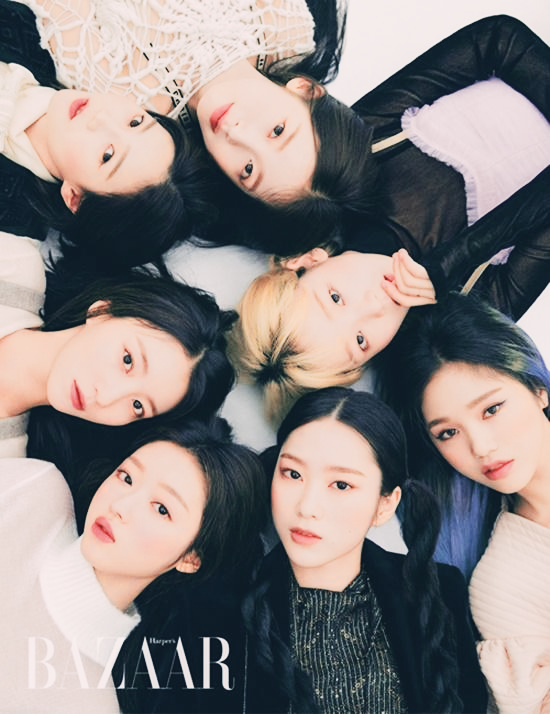

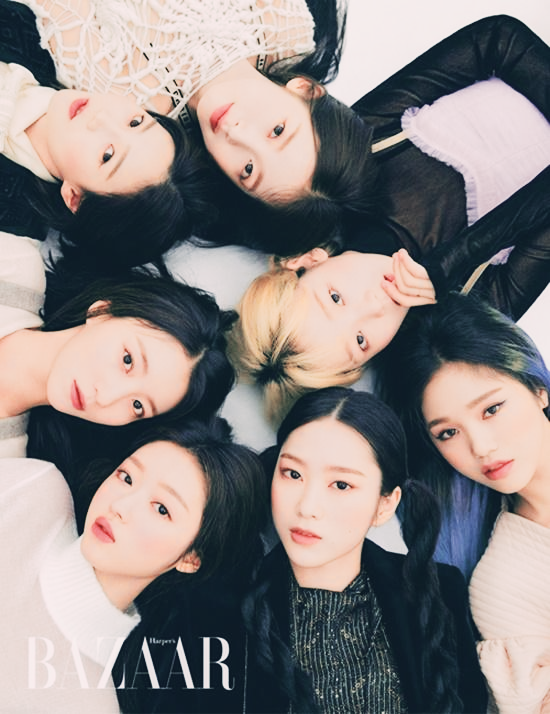

In [31]:
test_image = cv2.imread('test.jpg')
out = my_filter(test_image)
cv2_imshow(out)
out = model.predict(test_image[None])[0]
cv2_imshow(out)